In [1]:
#Basic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
    #Splitting database
from sklearn.model_selection import train_test_split

# 1 Load Dataset

In [2]:
full_df = pd.read_csv('full_df.csv')

In [3]:
full_df.shape

(9823, 3511)

# 2 Feature Selection

In [5]:
df = full_df[[
    'SEQN', # Participant ID
    'RIAGENDR', # Gender: 1=Male, 2=Female. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.htm#RIAGENDR
    'RIDAGEYR', # Age (years). Individuals 80 and over are topcoded at 80 years of age. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.htm#RIDAGEYR
    'BMXWT', # Weight (kg). https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/BMX_H.htm#BMXWT
    'PAXMINSB',# Sedentary behavior (minutes/day)
    'PAXMINLPA',# Light-intensity physical activity (minutes/day)
    'PAXMINMPA',# Moderate-intensity physical activity (minutes/day)
    'PAXMINVPA',# Vigorous-intensity physical activity (minutes/day)
    'PAXMINVVPA',# VVigorous-intensity physical activity (minutes/day)
    'TARGET_BINARY', # 1: Low Bone Density, 0: Healthy. Used as target for CLASSIFICATION
    'DXXNK_TSCORE' # T-Score at femoral neck. Used as target for REGRESSION
]]

# 3 Missing Values

In [6]:
df.isna().sum()

SEQN                0
RIAGENDR            0
RIDAGEYR            0
BMXWT             424
PAXMINSB         2336
PAXMINLPA        2336
PAXMINMPA        2336
PAXMINVPA        2336
PAXMINVVPA       2336
TARGET_BINARY    6926
DXXNK_TSCORE     6926
dtype: int64

# 4 Drop participants that have no target variable

In [7]:
df=df.dropna(subset=['TARGET_BINARY'])

In [8]:
df.shape

(2897, 11)

# 5 Drop participants that have no physical activity data

To filter physical activity data, we will use the following criteria:
1. Participants that have NaN values will be dropped (using the column `PAXMINSB` as reference)
2. Participants that were excluded from the time series matrix. In that matrix were included only days with 1440 minutes, and filter out subjects with less than 7 days of data (see 6_generate_time_series_matrix.ipynb)

In [9]:
df=df.dropna(subset=['PAXMINSB'])

In [10]:
df.shape

(2569, 11)

To filter out subjects that were excluded from the time series matrix, we will use the matrix_SEQN.csv file that contains the sequence number of the participants that were included in the time series matrix.

In [11]:
matrix_SEQN = pd.read_csv('matrix_SEQN.csv')

In [11]:
# Check the data type of the SEQN column in both dataframes
print(df['SEQN'].dtype)
print(matrix_SEQN['SEQN'].dtype)


float64
float64


In [12]:
# Filter df where 'SEQN' is in 'matrix_SEQN'
df = df[df['SEQN'].isin(matrix_SEQN['SEQN'])]

In [13]:
df.shape

(2508, 11)

In [14]:
df.isna().sum()

SEQN             0
RIAGENDR         0
RIDAGEYR         0
BMXWT            4
PAXMINSB         0
PAXMINLPA        0
PAXMINMPA        0
PAXMINVPA        0
PAXMINVVPA       0
TARGET_BINARY    0
DXXNK_TSCORE     0
dtype: int64

# 6 Drop participants that have no body weight data

In [15]:
df=df.dropna(subset=['BMXWT'])

In [16]:
# Size of the dataframe
df.shape

(2504, 11)

In [17]:
# Information about data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2504 entries, 1 to 9820
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SEQN           2504 non-null   float64
 1   RIAGENDR       2504 non-null   float64
 2   RIDAGEYR       2504 non-null   float64
 3   BMXWT          2504 non-null   float64
 4   PAXMINSB       2504 non-null   float64
 5   PAXMINLPA      2504 non-null   float64
 6   PAXMINMPA      2504 non-null   float64
 7   PAXMINVPA      2504 non-null   float64
 8   PAXMINVVPA     2504 non-null   float64
 9   TARGET_BINARY  2504 non-null   float64
 10  DXXNK_TSCORE   2504 non-null   float64
dtypes: float64(11)
memory usage: 234.8 KB


# 7 Data Visualization

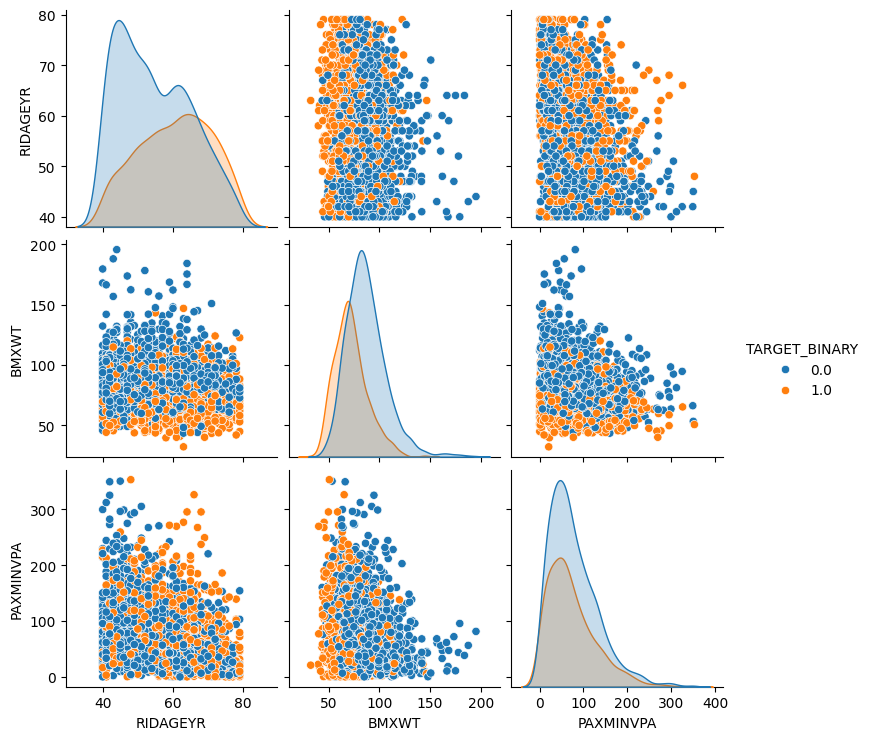

In [19]:
sns.pairplot(df[['RIDAGEYR','BMXWT','PAXMINVPA','TARGET_BINARY']],hue='TARGET_BINARY')
plt.show()

# 8 Split data into train and test sets

In [45]:
#X=df.iloc[:,1:-1].values # Exclusing Participant ID and TARGET_BINARY
#X=df.iloc[:,1:-1] # Including columns names so that they are displayed in the feature importance plot
X=df.iloc[:,:-2] # Including Participant ID. Exclusing the last two columns, that contain the target (binary and numerical)
y=df['TARGET_BINARY'].values

In [46]:
X.shape

(2504, 9)

In [47]:
y.shape

(2504,)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [49]:
# Get indices of the train and test sets
train_indices = X_train.index
test_indices = X_test.index

# Target values for the regression
y_train_reg = df.loc[train_indices, 'DXXNK_TSCORE'].values
y_test_reg = df.loc[test_indices, 'DXXNK_TSCORE'].values

In [50]:
X_train.shape, X_test.shape

((2003, 9), (501, 9))

In [51]:
y_train.shape, y_test.shape

((2003,), (501,))

In [52]:
y_train_reg.shape, y_test_reg.shape

((2003,), (501,))

In [53]:
y_train

array([1., 0., 1., ..., 1., 1., 0.])

In [54]:
y_train_reg

array([-2.16666667, -0.35      , -1.4       , ..., -1.79166667,
       -1.60833333, -0.84166667])

In [55]:
# Convert the indices to sets for easy comparison
original_IDs = set(df.SEQN)
train_IDs = set(X_train.SEQN)
test_IDs = set(X_test.SEQN)

In [56]:
# Check for overlap
assert len(train_IDs.intersection(test_IDs)) == 0, "Overlap found between train and test sets"

# Check for missing values
assert train_IDs.union(test_IDs) == original_IDs, "Some indices are missing in the split datasets"

# The `assert` statement is used in Python for debugging purposes. It tests whether a specified condition is `True`, and if it is not true, the program raises an `AssertionError` exception with an optional error message: assert condition, "Optional Error Message"

Save split IDs to csv files

In [57]:
def write_set_to_csv(my_set, filename):
    """Writes each element of a set to a new row in a CSV file."""
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        for element in my_set:
            writer.writerow([element])

In [58]:
write_set_to_csv(train_IDs, 'train_IDs.csv')
write_set_to_csv(test_IDs, 'test_IDs.csv')

In [59]:
# X: Features
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

# y: Labels for classification
pd.Series(y_train).to_csv('y_train.csv', index=False)
pd.Series(y_test).to_csv('y_test.csv', index=False)

# y reg: Numerical values for regression
pd.Series(y_train_reg).to_csv('y_train_regression.csv', index=False)
pd.Series(y_test_reg).to_csv('y_test_regression.csv', index=False)

# 9 Testing the split

In [60]:
def read_ids_from_csv(filename):
    """Reads IDs from a CSV file and returns them as a pandas Series."""
    return pd.read_csv(filename, header=None).squeeze("columns")

def filter_dataframe(df, ids, column='SEQN'):
    """Filters a dataframe based on a sequence of IDs."""
    return df[df[column].isin(ids)]

# Read train and test IDs from CSV files
train_ids = read_ids_from_csv('train_IDs.csv')
test_ids = read_ids_from_csv('test_IDs.csv')

# Assuming df is your dataframe
# Filter df based on train and test IDs
df_train = filter_dataframe(df, train_ids)
df_test = filter_dataframe(df, test_ids)

In [61]:
X_train.sort_values(by=['SEQN'])

,SEQN,RIAGENDR,RIDAGEYR,BMXWT,PAXMINSB,PAXMINLPA,PAXMINMPA,PAXMINVPA,PAXMINVVPA
1,73558.0,1.0,54.0,89.5,74.165056,382.612084,355.949730,38.770919,2.177174
4,73561.0,2.0,73.0,52.0,129.681098,374.825029,241.415292,18.089855,0.000000
7,73564.0,2.0,61.0,93.4,87.001290,281.251652,365.126874,51.604224,1.366919
9,73566.0,2.0,56.0,61.8,64.924196,138.734097,427.757015,220.166006,13.652564
10,73567.0,1.0,65.0,65.3,27.547406,303.020141,429.918298,37.206726,0.698651
...,...,...,...,...,...,...,...,...,...
9795,83701.0,2.0,45.0,69.7,104.815707,317.686811,378.342147,57.618823,6.268335
9801,83708.0,1.0,64.0,175.2,127.253299,450.548209,235.359577,10.865159,0.256923
9813,83721.0,1.0,52.0,79.5,33.063431,217.342950,380.421475,37.337409,1.203095
9815,83723.0,1.0,61.0,99.5,65.613633,332.777319,446.764175,28.698456,0.589485


In [62]:
df_train.iloc[:,:-2]

,SEQN,RIAGENDR,RIDAGEYR,BMXWT,PAXMINSB,PAXMINLPA,PAXMINMPA,PAXMINVPA,PAXMINVVPA
1,73558.0,1.0,54.0,89.5,74.165056,382.612084,355.949730,38.770919,2.177174
4,73561.0,2.0,73.0,52.0,129.681098,374.825029,241.415292,18.089855,0.000000
7,73564.0,2.0,61.0,93.4,87.001290,281.251652,365.126874,51.604224,1.366919
9,73566.0,2.0,56.0,61.8,64.924196,138.734097,427.757015,220.166006,13.652564
10,73567.0,1.0,65.0,65.3,27.547406,303.020141,429.918298,37.206726,0.698651
...,...,...,...,...,...,...,...,...,...
9795,83701.0,2.0,45.0,69.7,104.815707,317.686811,378.342147,57.618823,6.268335
9801,83708.0,1.0,64.0,175.2,127.253299,450.548209,235.359577,10.865159,0.256923
9813,83721.0,1.0,52.0,79.5,33.063431,217.342950,380.421475,37.337409,1.203095
9815,83723.0,1.0,61.0,99.5,65.613633,332.777319,446.764175,28.698456,0.589485


In [64]:
# Ensure the values are the same
assert (X_train.sort_values(by=['SEQN']).values == df_train.iloc[:, :-2].sort_values(by=['SEQN']).values).all(), "Values are different"

In [65]:
assert (X_test.sort_values(by=['SEQN']).values == df_test.iloc[:, :-2].sort_values(by=['SEQN']).values).all(), "Values are different"